In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the dataset
file_path = '/content/drive/MyDrive/MSDS/Time Series and Forecasting Project/airline_passenger_data.csv'

data = pd.read_csv(file_path)
print(data.head())



     Month  Thousands of Passengers
0  1949-01                      112
1  1949-02                      118
2  1949-03                      132
3  1949-04                      129
4  1949-05                      121


In [2]:

# Convert the 'Month' column to datetime
data['Month'] = pd.to_datetime(data['Month'])

# Set the 'Month' column as the index for time-series analysis
data.set_index('Month', inplace=True)
ndata = data.copy()
print(data.head())
# print(ndata.head())

            Thousands of Passengers
Month                              
1949-01-01                      112
1949-02-01                      118
1949-03-01                      132
1949-04-01                      129
1949-05-01                      121


In [3]:


# Summary Statistics
summary_stats = data.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
       Thousands of Passengers
count               144.000000
mean                280.298611
std                 119.966317
min                 104.000000
25%                 180.000000
50%                 265.500000
75%                 360.500000
max                 622.000000


In [4]:

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)



Missing Values:
Thousands of Passengers    0
dtype: int64


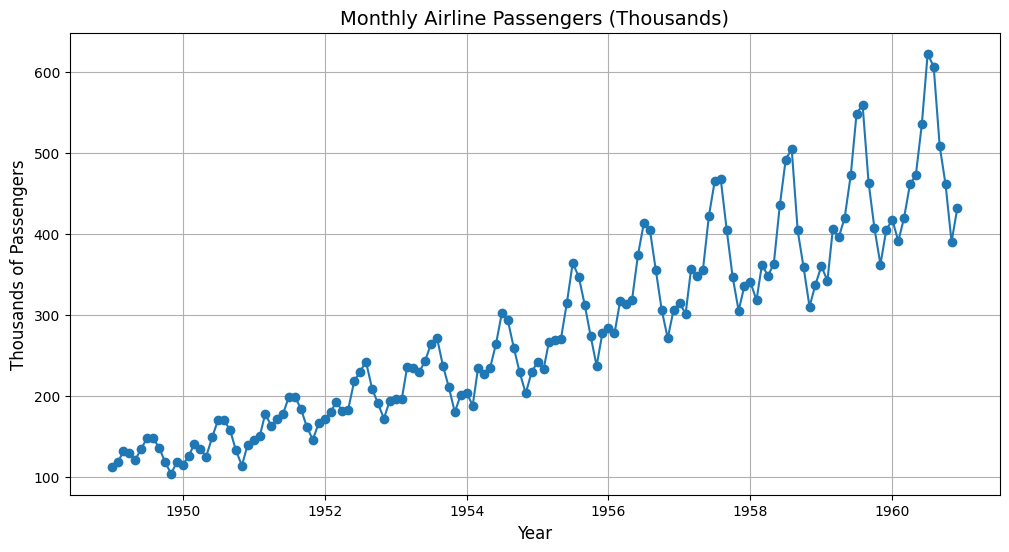

In [5]:

# Plot the time series to analyze trends
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Thousands of Passengers'], marker='o', linestyle='-')
plt.title('Monthly Airline Passengers (Thousands)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Thousands of Passengers', fontsize=12)
plt.grid()
plt.show()


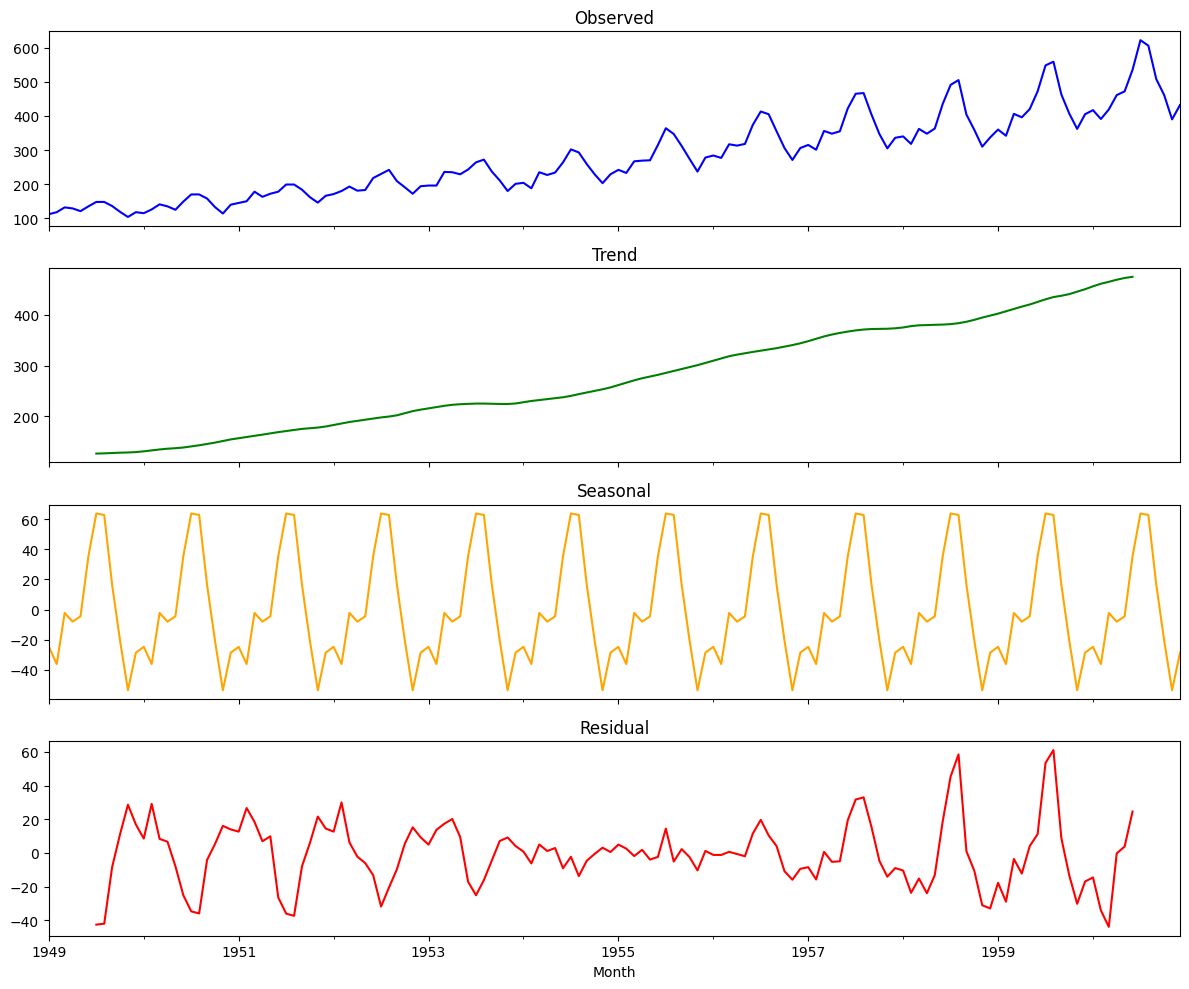

In [6]:

# Decompose the time series
decomposition = seasonal_decompose(data['Thousands of Passengers'], model='additive', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='orange')
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')
plt.tight_layout()
plt.show()


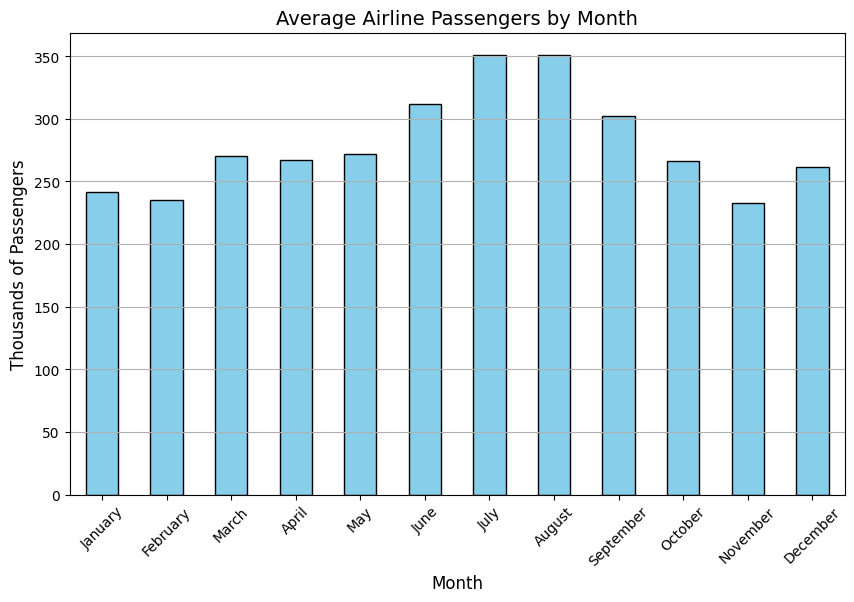

In [7]:

# Extract month names for detailed analysis
data['Month_Name'] = data.index.month_name()

# Group by month to analyze seasonality
monthly_seasonality = data.groupby('Month_Name')['Thousands of Passengers'].mean()
monthly_seasonality = monthly_seasonality.reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Plot the average passengers by month
plt.figure(figsize=(10, 6))
monthly_seasonality.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Airline Passengers by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Thousands of Passengers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


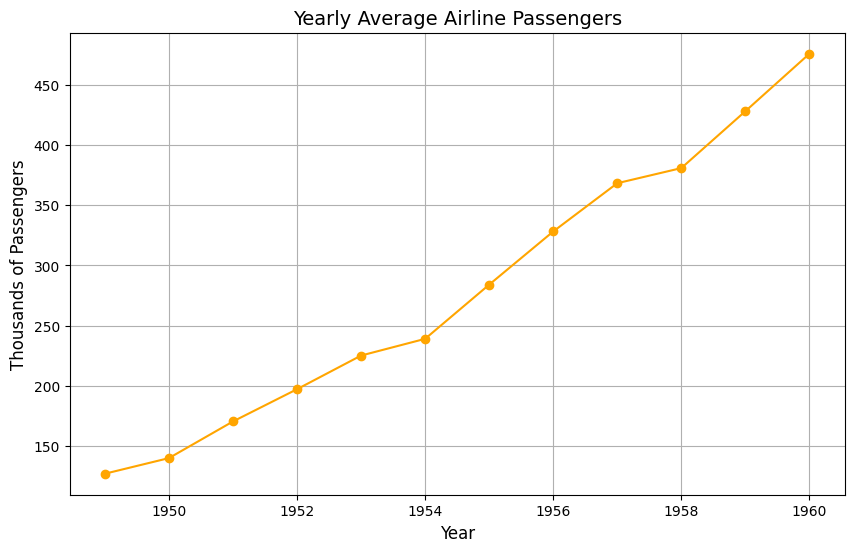

In [8]:

# Group by year to analyze yearly trends
data['Year'] = data.index.year
yearly_trends = data.groupby('Year')['Thousands of Passengers'].mean()

# Plot the yearly trend
plt.figure(figsize=(10, 6))
yearly_trends.plot(marker='o', linestyle='-', color='orange')
plt.title('Yearly Average Airline Passengers', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Thousands of Passengers', fontsize=12)
plt.grid()
plt.show()


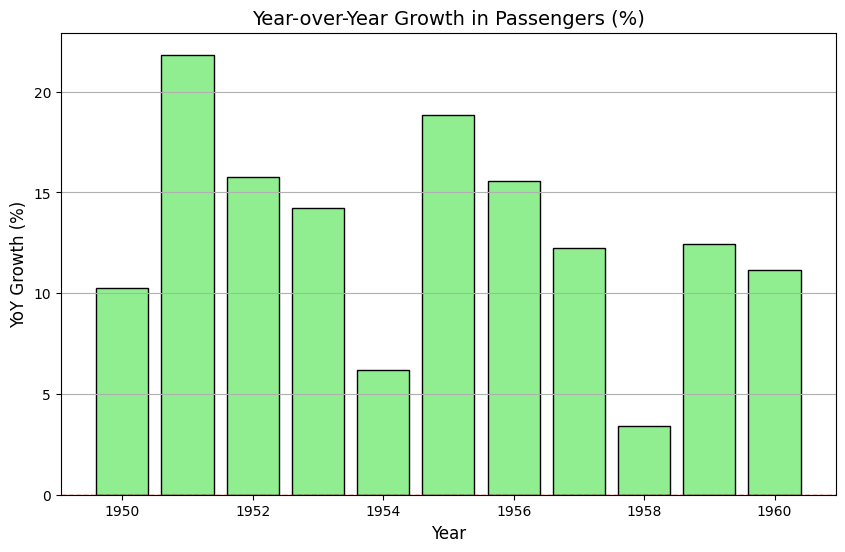

In [9]:

# Year-over-Year (YoY) Growth Rate
yearly_data = data.groupby('Year')['Thousands of Passengers'].sum().reset_index()
yearly_data['YoY Growth (%)'] = yearly_data['Thousands of Passengers'].pct_change() * 100

# Plot the YoY growth
plt.figure(figsize=(10, 6))
plt.bar(yearly_data['Year'], yearly_data['YoY Growth (%)'], color='lightgreen', edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Year-over-Year Growth in Passengers (%)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('YoY Growth (%)', fontsize=12)
plt.grid(axis='y')
plt.show()


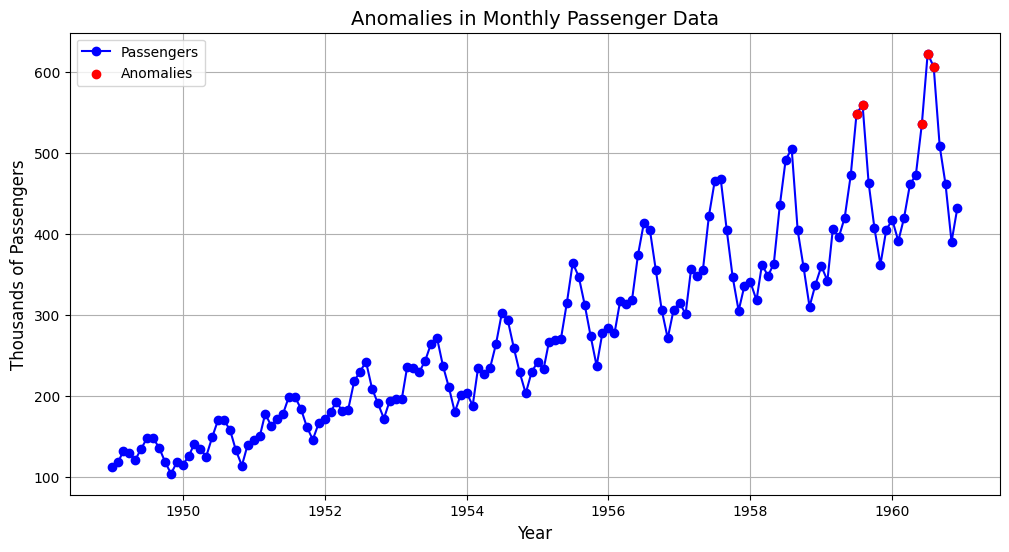

In [10]:

# Anomaly Detection using Z-scores
data['Z-Score'] = zscore(data['Thousands of Passengers'])
anomalies = data[(data['Z-Score'] > 2) | (data['Z-Score'] < -2)]

# Highlight anomalies on a time series plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Thousands of Passengers'], label='Passengers', color='blue', marker='o', linestyle='-')
plt.scatter(anomalies.index, anomalies['Thousands of Passengers'], color='red', label='Anomalies', zorder=5)
plt.title('Anomalies in Monthly Passenger Data', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Thousands of Passengers', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pandas.tseries.offsets import DateOffset

# Initialize parameters for model predictions
start_window = 24  # Start with 24 months (or any appropriate starting window)
sarima_preds = []
es_preds = []
actual = ndata['Thousands of Passengers'][start_window:]  # Exclude initial window from actuals

# Define function to calculate error metrics
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Apply expanding window approach across the ndataset
for end in range(start_window, len(ndata)):
    train_window = ndata.iloc[:end]  # Expanding window up to current end point

    # SARIMA Model (seasonal ARIMA)
    sarima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
    sarima_model = SARIMAX(train_window, order=sarima_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fit.forecast(steps=1)
    sarima_preds.append(sarima_forecast.values[0])

    # Exponential Smoothing Model
    es_model = ExponentialSmoothing(train_window, seasonal='mul', seasonal_periods=12)
    es_fit = es_model.fit()
    es_forecast = es_fit.forecast(steps=1)
    es_preds.append(es_forecast.values[0])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

In [12]:

# Create DataFrame to store actual vs predicted values
predictions_df = pd.DataFrame({
    'Actual': actual.values,
    'SARIMA_Predictions': sarima_preds,
    'Exponential_Smoothing_Predictions': es_preds
}, index=actual.index)

print("\nPredicted Data:")
print(predictions_df)



Predicted Data:
            Actual  SARIMA_Predictions  Exponential_Smoothing_Predictions
Month                                                                    
1951-01-01     145          140.963083                         133.668853
1951-02-01     150          154.420239                         153.768249
1951-03-01     178          163.478718                         166.153609
1951-04-01     163          180.564427                         169.763926
1951-05-01     172          152.962477                         149.817107
...            ...                 ...                                ...
1960-08-01     606          630.053902                         621.103740
1960-09-01     508          513.397622                         515.010497
1960-10-01     461          456.569640                         441.589601
1960-11-01     390          416.280302                         395.553401
1960-12-01     432          440.880212                         432.633846

[120 rows x 3 column

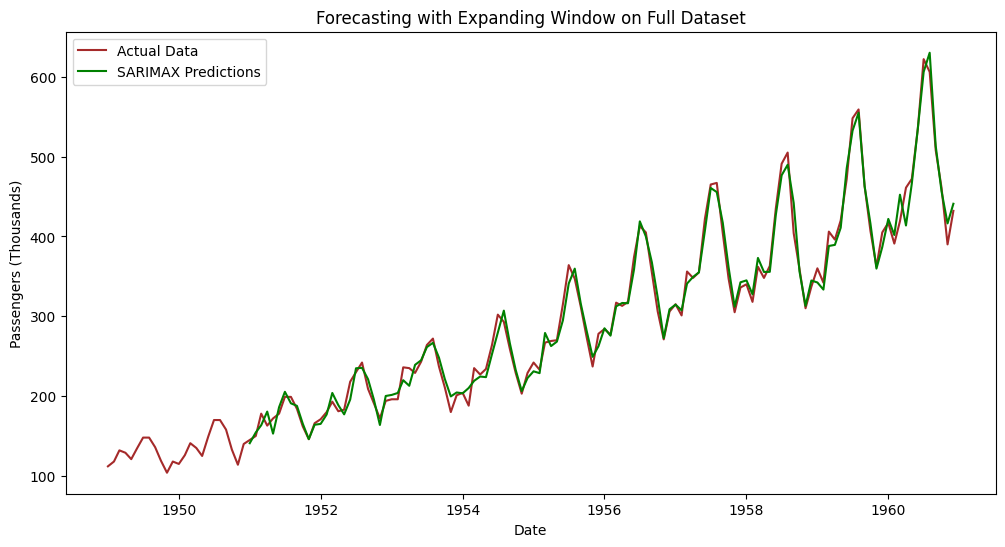

In [13]:
# for sarima
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Thousands of Passengers'], label='Actual Data', color='brown')
plt.plot(actual.index, sarima_preds, label='SARIMAX Predictions', color='green')
plt.title("Forecasting with Expanding Window on Full Dataset")
plt.xlabel("Date")
plt.ylabel("Passengers (Thousands)")
plt.legend()
plt.show()


In [14]:

# Evaluate models
sarima_mae, sarima_rmse = evaluate_forecast(actual, sarima_preds)
es_mae, es_rmse = evaluate_forecast(actual, es_preds)

# Display results
print(f"SARIMA - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")


SARIMA - MAE: 9.70, RMSE: 12.47


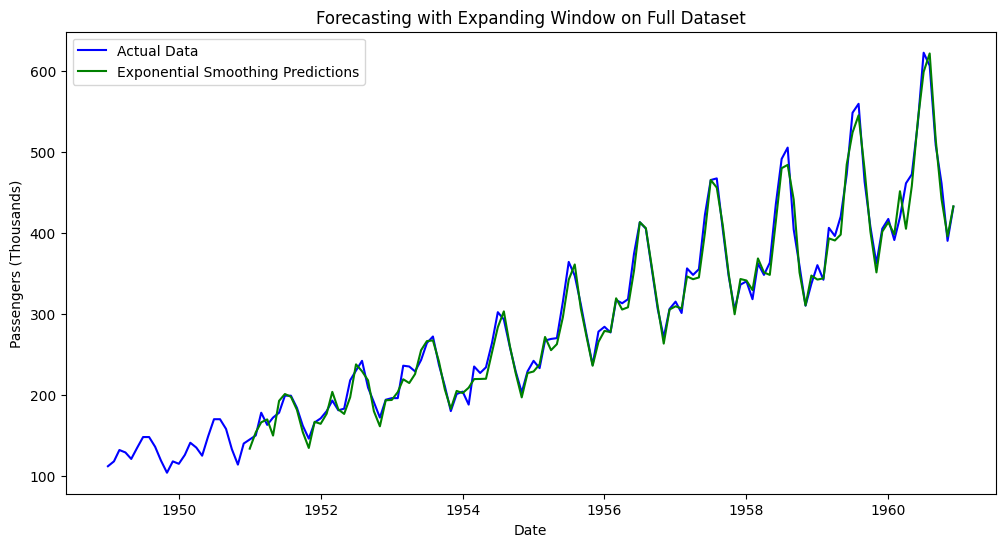

In [15]:
# for holt-winters exponential smoothing
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Thousands of Passengers'], label='Actual Data', color='blue')
plt.plot(actual.index, es_preds, label='Exponential Smoothing Predictions', color='green')
plt.title("Forecasting with Expanding Window on Full Dataset")
plt.xlabel("Date")
plt.ylabel("Passengers (Thousands)")
plt.legend()
plt.show()


In [16]:
print(f"Exponential Smoothing - MAE: {es_mae:.2f}, RMSE: {es_rmse:.2f}")


Exponential Smoothing - MAE: 9.54, RMSE: 12.72


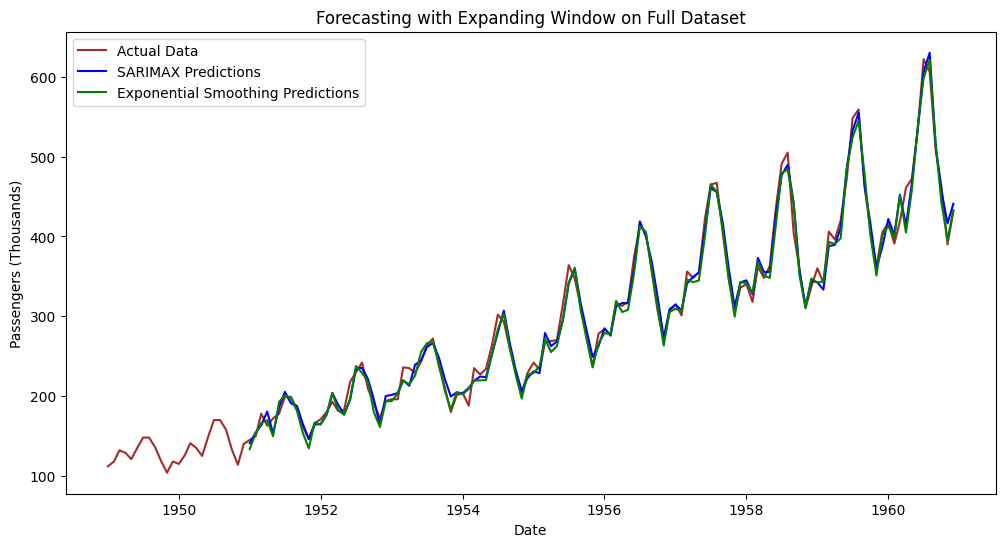

In [17]:
# for both sarima and exponentail smoothing
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data['Thousands of Passengers'], label='Actual Data', color='brown')
plt.plot(actual.index, sarima_preds, label='SARIMAX Predictions', color='blue')
plt.plot(actual.index, es_preds, label='Exponential Smoothing Predictions', color='green')
plt.title("Forecasting with Expanding Window on Full Dataset")
plt.xlabel("Date")
plt.ylabel("Passengers (Thousands)")
plt.legend()
plt.show()


In [19]:

# Save predictions to a CSV if needed
predictions_df.to_csv('/content/drive/MyDrive/MSDS/Time Series and Forecasting Project/predicted_data.csv')